# Tweaked ResNet50  for 48x48x1 inputs

Made few chages in the first convolution and pooling layer of ResNet50 such that initial infomation loss is avoided for small (48x48) size input image

References:  
&nbsp;&nbsp;\[1\] [Resnet with Keras](https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb)  
&nbsp;&nbsp;\[2\] [Kaggle Facial Expression DataSet](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge) is of grayscale 48x48 size images

In [0]:
import numpy as np
import keras
regularizers = keras.regularizers
K = keras.backend

Using TensorFlow backend.


### Define Residual(=Identity) Bock

In [0]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = keras.layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', 
                            kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = keras.layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', 
                            kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = keras.layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', 
                            kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(gamma_initializer='zeros', axis = 3, name = bn_name_base + '2c')(X)


    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)
    
    
    return X

### Define Down-sampling(=Convolution) Bock

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = keras.layers.Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', 
                            kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = keras.layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', 
                            kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = keras.layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', 
                            kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = keras.layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)
    
    return X

### Define ResNet50

In [0]:
def get_resnet50_48x48(input_shape=(48, 48, 1), classes=7):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = keras.layers.Input(input_shape)

    # Zero-Padding
    X = keras.layers.ZeroPadding2D((2, 2))(X_input)

    # Stage 1
    X = keras.layers.Conv2D(64, (5, 5), strides=(1, 1), name='conv1', 
		                        kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = keras.layers.Activation('relu')(X)	
    # X = keras.layers.ZeroPadding2D((1, 1))(X)


    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    # X = keras.layers.AveragePooling2D((2,2), name="avg_pool")(X)
    # X = keras.layers.GlobalAveragePooling2D(name="avg_pool")(X)

    ### END CODE HERE ###

    # Create model
    model = keras.models.Model(inputs = X_input, outputs = X, name='resnet50_48x48')

    return model

In [0]:
resnet50_48x48 = get_resnet50_48x48()
resnet50_48x48.summary()

W0815 18:57:27.729105 140476635953024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 18:57:27.744785 140476635953024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 18:57:27.751296 140476635953024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 18:57:27.776646 140476635953024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0815 18:57:27.777465 1404766359

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 52, 52, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   1664        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
# model = keras.applications.resnet50.ResNet50(weights='imagenet')
# model.summary()

### Add subnet for classification

In [0]:
model = keras.models.Sequential()
model.add(resnet50_48x48)
model.add(keras.layers.GlobalAveragePooling2D(name='global_ave_pool'))
model.add(keras.layers.Dense(units=2048,name='FC1'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(units=128,name='FC2'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(7, activation='softmax'))
model.summary()

W0815 18:57:37.187885 140476635953024 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_48x48 (Model)       (None, 6, 6, 2048)        23579904  
_________________________________________________________________
global_ave_pool (GlobalAvera (None, 2048)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation_50 (Activation)   (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
FC2 (Dense)                  (None, 128)               262272    
__________

In [0]:
# model.add(keras.layers.Conv2D(filters=256),kernal_size=(3,3),name='classification_conv1')
# model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.Conv2D(filters=256),kernal_size=(3,3),name='classification_conv2')
# model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.Conv2D(filters=256),kernal_size=(3,3),name='classification_conv3')
# model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.Conv2D(filters=256),kernal_size=(3,3),name='classification_conv4')
# model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.Conv2D(filters=7*9),kernal_size=(3,3),name='classification_conv5')

### Load Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
data_path = '/content/drive/My Drive/WorkSpace/MLstudy/GDSO2019/data/'

Mounted at /content/drive/


In [0]:
import pickle
with open(data_path+'FER2013.train_data.pickle','rb') as f:
  train_data = pickle.load(f)
with open(data_path+'FER2013.public_test_data.pickle','rb') as f:
  public_test_data = pickle.load(f)

In [0]:
sample_count = len(train_data['y'])

### Cos decay with warm-up

In [0]:
base_batch_size = 256
base_lr = 0.1
multiplier = 0.5
batch_size = int(base_batch_size * multiplier)
initial_lr = base_lr * multiplier
warmup_epoch = 2
epochs = 25

In [0]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0,
                             learning_rate_min = 0.0001): 
    """Cosine decay schedule with warm up period.

    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.

    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.

    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps))) + learning_rate_min
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base + learning_rate_min < warmup_learning_rate:
            raise ValueError('learning_rate_base + learning_rate_min must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base + learning_rate_min - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, learning_rate_min, learning_rate) # keep learing after fully decayed (Kilean)



class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.

    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))


warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=initial_lr,
                                        total_steps = int(epochs * sample_count / batch_size),
                                        warmup_learning_rate =0.0002,
                                        warmup_steps = int(warmup_epoch * sample_count / batch_size),
                                        hold_base_rate_steps=0)

#### Label Smoothing

In [0]:
def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y

In [0]:
print('Before smoothing: {}'.format(train_data['y'][0]))
smooth_labels(train_data['y'], .02)
print('After smoothing: {}'.format(train_data['y'][0]))

Before smoothing: [1. 0. 0. 0. 0. 0. 0.]
After smoothing: [0.98285717 0.00285714 0.00285714 0.00285714 0.00285714 0.00285714
 0.00285714]


### Train

In [0]:
check_point = keras.callbacks.ModelCheckpoint(data_path+'ResNet50_48x48.cosDecay.LabelSmoothing.zeroGamma.epoch={epoch:02d}.acc={acc:.2f}.val_acc={val_acc:.2f}.hdf5', monitor='val_loss', verbose=0, 
                                              save_best_only=True, save_weights_only=False, mode='auto', period=1)
stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

hist = model.fit(train_data['x'], train_data['y'],
                    validation_data=(public_test_data['x'], public_test_data['y']),
                    epochs = 100, batch_size = 128, callbacks=[check_point,stopping,warm_up_lr])

with open(data_path+'ResNet50_48x48.cosDecay.LabelSmoothing.zeroGamma.hist.pickle','wb') as f:
  pickle.dump(hist,f)

W0815 18:57:42.134176 140476635953024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0815 18:57:42.308423 140476635953024 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 278s 10ms/step - loss: 1.8375 - acc: 0.2674 - val_loss: 13.8891 - val_acc: 0.1382
Epoch 2/100
28709/28709 [==============================] - 252s 9ms/step - loss: 1.6270 - acc: 0.3691 - val_loss: 14.2540 - val_acc: 0.1156
Epoch 3/100
28709/28709 [==============================] - 250s 9ms/step - loss: 1.4964 - acc: 0.4302 - val_loss: 2.9641 - val_acc: 0.3185
Epoch 4/100
28709/28709 [==============================] - 249s 9ms/step - loss: 1.4009 - acc: 0.4734 - val_loss: 4.5761 - val_acc: 0.3330
Epoch 5/100
28709/28709 [==============================] - 248s 9ms/step - loss: 1.3465 - acc: 0.4985 - val_loss: 1.7145 - val_acc: 0.4046
Epoch 6/100
28709/28709 [==============================] - 248s 9ms/step - loss: 1.2990 - acc: 0.5195 - val_loss: 2.5129 - val_acc: 0.2800
Epoch 7/100
28709/28709 [==============================] - 248s 9ms/step - loss: 1.2583 - acc: 0.5384 - val_loss: 

In [0]:
import matplotlib.pyplot as plt

In [0]:
with open(data_path+'ResNet50_48x48.hist.pickle','rb') as f:
  hist = pickle.load(f)

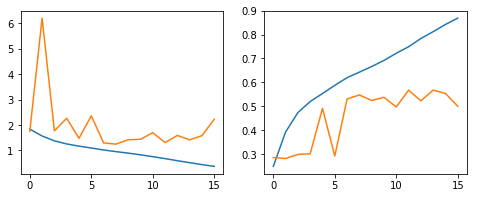

In [0]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [0]:
with open(data_path+'ResNet50_48x48.cosDecay.hist.pickle','rb') as f:
  hist = pickle.load(f)

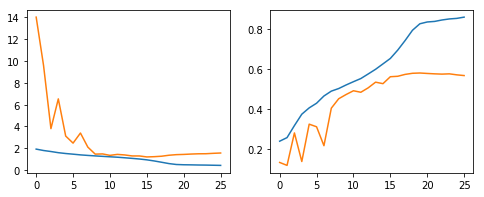

In [0]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [0]:
with open(data_path+'ResNet50_48x48.cosDecay.LabelSmoothing.hist.pickle','rb') as f:
  hist = pickle.load(f)

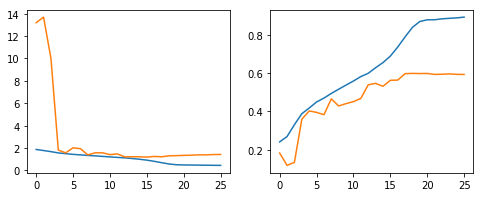

In [0]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [0]:
with open(data_path+'ResNet50_48x48.cosDecay.LabelSmoothing.zeroGamma.hist.pickle','rb') as f:
  hist = pickle.load(f)

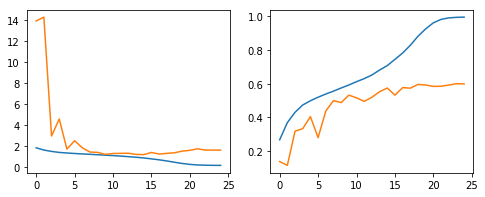

In [0]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])